In [ ]:
import os
import numpy as np
import pandas as pd
import torch
from glob import glob
from natsort import natsorted
from torch.utils.data import Dataset , DataLoader

import nibabel as nib
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import transforms
import random

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

folder_path = "/content/drive/My Drive/MICCAI_BraTS2020_TrainingData"

if os.path.exists(folder_path):
    print("Folder exists.")
else:
    print("Folder does not exist.")


Folder exists.


In [ ]:
torch.cuda.empty_cache()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu' )
device

device(type='cpu')

In [ ]:
len(os.listdir(folder_path))

135

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import nibabel as nib
from glob import glob
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset

class BraTSDataLoader(Dataset):

    def __init__(self, path, transform=None, scaler=MinMaxScaler(), device="cpu",a=0,b=None):
        self.path = path
        self.device = device  # Store device information
        self.a = a
        self.b=b

        # Load file paths
        self.flair = sorted(glob(self.path + '/*/*flair.nii'))[self.a : self.b]
        self.t1 = sorted(glob(self.path + '/*/*t1.nii'))[self.a : self.b]
        self.t1ce = sorted(glob(self.path + '/*/*t1ce.nii'))[self.a : self.b]
        self.t2 = sorted(glob(self.path + '/*/*t2.nii'))[self.a : self.b]
        self.mask = sorted(glob(self.path + '/*/*seg.nii'))[self.a : self.b]

        self.scaler = scaler
        self.transform = transform

        print(len(self.t1))
        print(len(self.t1))
        print(len(self.t1ce))
        print(len(self.flair))
        print(len(self.mask))

        # Ensure all modalities have the same length
        assert len(self.t1) == len(self.t2) == len(self.t1ce) == len(self.flair) == len(self.mask)

    def __len__(self):
        return len(self.t1)  # Length of dataset

    def __getitem__(self, idx):
        # Load images
        temp_flair = nib.load(self.flair[idx]).get_fdata()
        temp_t1 = nib.load(self.t1[idx]).get_fdata()
        temp_t1ce = nib.load(self.t1ce[idx]).get_fdata()
        temp_t2 = nib.load(self.t2[idx]).get_fdata()
        temp_mask = nib.load(self.mask[idx]).get_fdata().astype(np.uint8)

        # Normalize images
        temp_flair = self.scaler.fit_transform(temp_flair.reshape(-1, 1)).reshape(temp_flair.shape)
        temp_t1 = self.scaler.fit_transform(temp_t1.reshape(-1, 1)).reshape(temp_t1.shape)
        temp_t1ce = self.scaler.fit_transform(temp_t1ce.reshape(-1, 1)).reshape(temp_t1ce.shape)
        temp_t2 = self.scaler.fit_transform(temp_t2.reshape(-1, 1)).reshape(temp_t2.shape)

        # Fix mask labels by replacing 4 with 3
        temp_mask[temp_mask == 4] = 3

        # Stack image modalities (H, W, D, C)
        temp_combined_x = np.stack([temp_flair, temp_t1, temp_t1ce, temp_t2], axis=3)  # (H, W, D, C)

        # One-hot encode mask
        temp_mask = torch.tensor(temp_mask, dtype=torch.long, device=self.device)
        temp_mask = nn.functional.one_hot(temp_mask, num_classes=4).permute(3, 0, 1, 2)  # (C, H, W, D)

        # Crop images and masks to 128x128x128
        temp_combined_x = temp_combined_x[60:188, 60:188, 20:148]  # (128, 128, 128, 4)
        temp_mask = temp_mask[:, 60:188, 60:188, 20:148]  # (4, 128, 128, 128)

        # Convert to PyTorch tensors and send to device
        temp_combined_x = torch.tensor(temp_combined_x, dtype=torch.float, device=self.device).permute(3, 0, 1, 2)  # (4, 128, 128, 128)

        if self.transform:
            temp_combined_x = self.transform(temp_combined_x)
            temp_mask = self.transform(temp_mask)

        return temp_combined_x, temp_mask


In [ ]:
train_path = folder_path

BraTSdataTrain = BraTSDataLoader(train_path,a=0,b=134,device=device)

134
134
134
134
134


In [ ]:
for i, j in BraTSdataTrain:
    print(f"Train Input shape: {i.shape}")
    print(f"Train Label shape: {j.shape}")
    break
print(f" Data train : {len(BraTSdataTrain)}")
# its also can be called as len(BraTSDataLoader(train_path)) bcz its DUNDER call.....



Train Input shape: torch.Size([4, 128, 128, 128])
Train Label shape: torch.Size([4, 128, 128, 128])
 Data train : 134


In [ ]:
train_size = int(0.85 * len(BraTSdataTrain))  # %80 train
val_size = int(0.075 * len(BraTSdataTrain))  # 10% validation
test_size = len(BraTSdataTrain) - train_size - val_size  # Remaining for test

In [ ]:
from torch.utils.data import DataLoader, random_split

train_dataset, val_dataset, test_dataset = random_split(
    BraTSdataTrain,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  # Set seed for reproducibility
)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

In [ ]:
for i, j in train_loader:
    print(f"Train Input shape: {i.shape}")
    print(f"Train Label shape: {j.shape}")
    break
print(f"train Data with batch = 2 : {len(BraTSdataTrain)}")

Train Input shape: torch.Size([2, 4, 128, 128, 128])
Train Label shape: torch.Size([2, 4, 128, 128, 128])
train Data with batch = 2 : 134


Batch Data Shape: torch.Size([2, 4, 128, 128, 128])
Batch Labels Shape: torch.Size([2, 4, 128, 128, 128])
Sample Data Shape: torch.Size([4, 128, 128, 128])
Sample Label Shape: torch.Size([4, 128, 128, 128])


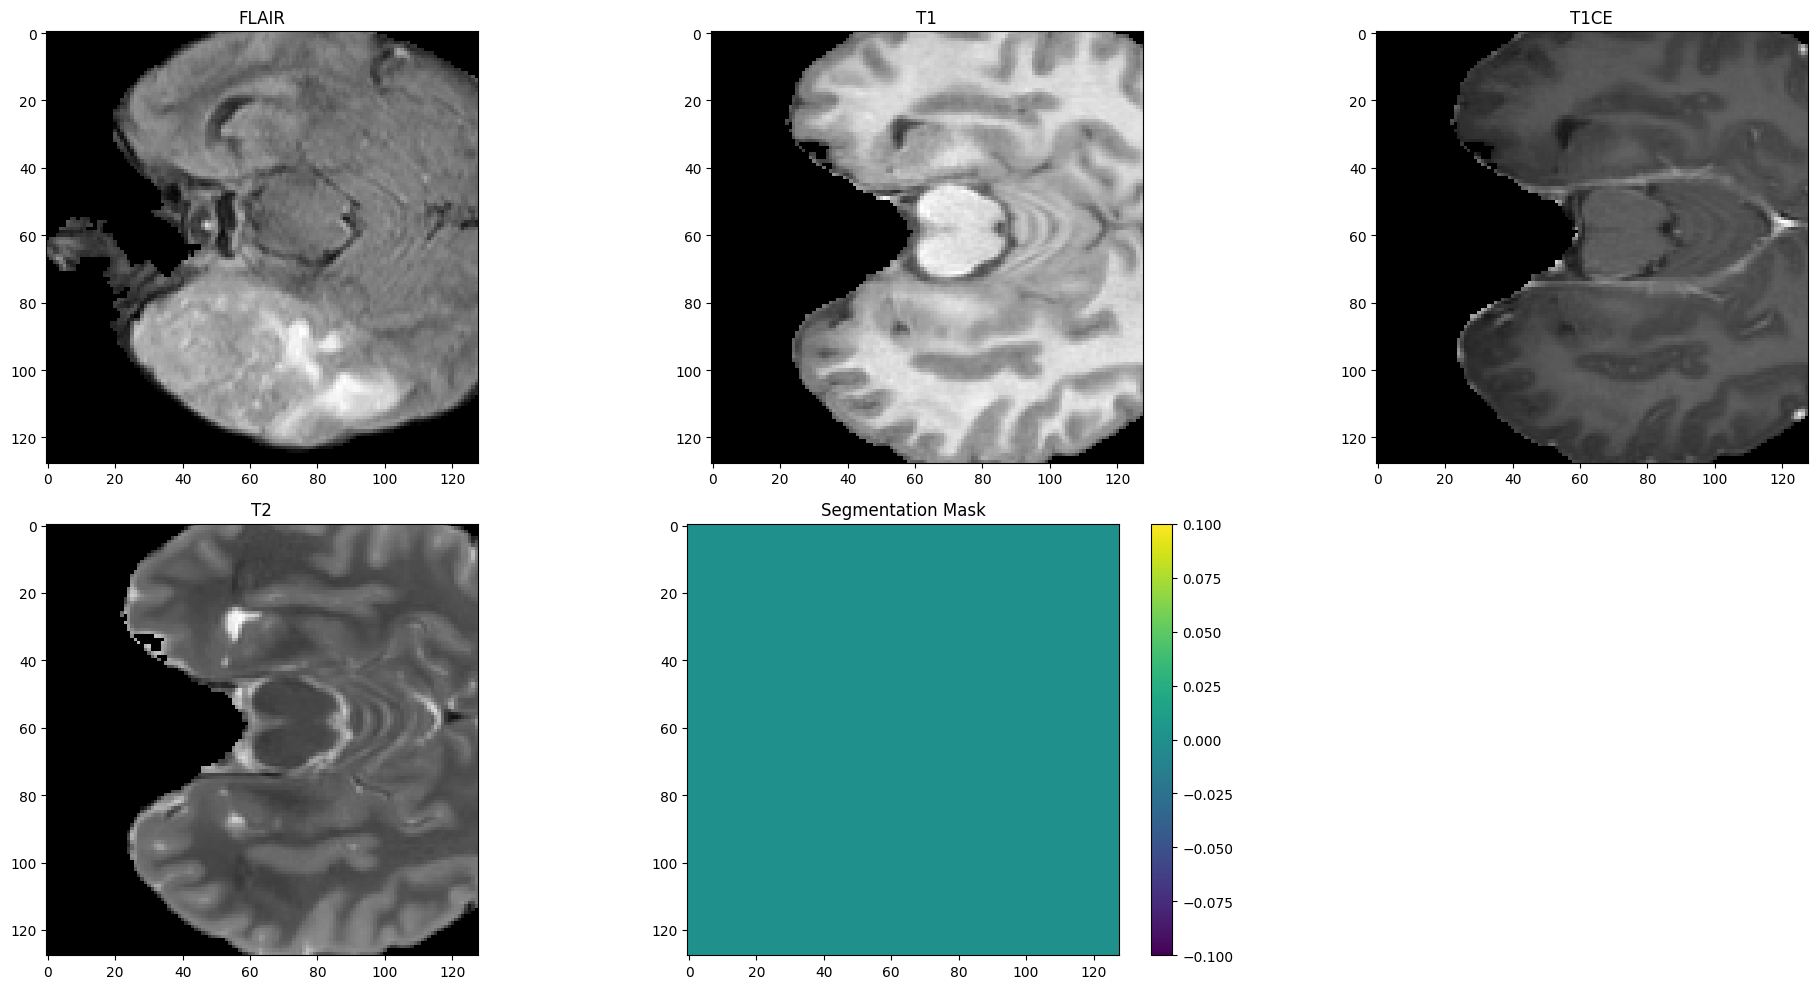

Selected Slice Index: 28
Unique Values in Segmentation Mask: [0]


In [ ]:
# Load a batch from the DataLoader
for batch_data, batch_labels in train_loader:
    batch_data = batch_data.to(device)  # Move input data to GPU/CPU
    batch_labels = batch_labels.to(device)  # Move labels to GPU/CPU

    print(f"Batch Data Shape: {batch_data.shape}")  # Expected: [batch_size, 4, 128, 128, 128]
    print(f"Batch Labels Shape: {batch_labels.shape}")  # Expected: [batch_size, 128, 128, 128, 4]
    break  # Just check the first batch

# Select the first sample
a, b = batch_data[0], batch_labels[0]  # Shape: (4, 128, 128, 128) and (128, 128, 128, 4)

print(f"Sample Data Shape: {a.shape}")  # [4, 128, 128, 128]
print(f"Sample Label Shape: {b.shape}")  # [128, 128, 128, 4]

# Select a random slice
n_slice = random.randint(0, b.shape[2] - 1)  # Select along the depth axis

# Visualization
plt.figure(figsize=(20, 10))

# Display the four MRI modalities
plt.subplot(231)
plt.imshow(a[0, :, :, n_slice].cpu().numpy(), cmap='gray')  # FLAIR
plt.title("FLAIR")

plt.subplot(232)
plt.imshow(a[1, :, :, n_slice].cpu().numpy(), cmap='gray')  # T1
plt.title("T1")

plt.subplot(233)
plt.imshow(a[2, :, :, n_slice].cpu().numpy(), cmap='gray')  # T1CE
plt.title("T1CE")

plt.subplot(234)
plt.imshow(a[3, :, :, n_slice].cpu().numpy(), cmap='gray')  # T2
plt.title("T2")

plt.subplot(235)
# Convert one-hot encoded mask back to categorical values
mask_display = torch.argmax(b, dim=0).cpu().numpy()[:, :, n_slice]
plt.imshow(mask_display, cmap='viridis')  # Use a proper colormap
plt.colorbar()
plt.title("Segmentation Mask")


plt.tight_layout()
plt.show()

print(f"Selected Slice Index: {n_slice}")
print(f"Unique Values in Segmentation Mask: {np.unique(mask_display)}")


In [ ]:
print(f"Mask Shape: {b.shape}")  # Expected: [128, 128, 128, 4]
print(f"Unique Values in Mask: {np.unique(torch.argmax(b, dim=0).cpu().numpy())}")



Mask Shape: torch.Size([4, 128, 128, 128])
Unique Values in Mask: [0 1 2 3]


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNetEncoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetEncoder, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(out_channels)
        self.pool = nn.MaxPool3d(2, 2)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        skip = x
        x = self.pool(x)
        return x, skip


class UNetDecoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetDecoder, self).__init__()
        self.upconv = nn.ConvTranspose3d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv1 = nn.Conv3d(out_channels * 2, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(out_channels)

    def forward(self, x, skip):
        x = self.upconv(x)
        x = torch.cat([x, skip], dim=1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        return x


class UNetBottleneck(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetBottleneck, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(out_channels)
        self.dropout = nn.Dropout3d(0.3)  # %30 dropout

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.dropout(x)
        return x


class UnetModel(nn.Module):
    def __init__(self, num_classes):
        super(UnetModel, self).__init__()

        self.encoder1 = UNetEncoder(4, 32)
        self.encoder2 = UNetEncoder(32, 64)
        self.encoder3 = UNetEncoder(64, 128)
        self.encoder4 = UNetEncoder(128, 256)

        self.bottleneck = UNetBottleneck(256, 512)

        self.decoder1 = UNetDecoder(512, 256)
        self.decoder2 = UNetDecoder(256, 128)
        self.decoder3 = UNetDecoder(128, 64)
        self.decoder4 = UNetDecoder(64, 32)

        self.final_conv = nn.Conv3d(32, num_classes, kernel_size=1)

    def forward(self, x):
        x, skip1 = self.encoder1(x)
        x, skip2 = self.encoder2(x)
        x, skip3 = self.encoder3(x)
        x, skip4 = self.encoder4(x)

        x = self.bottleneck(x)

        x = self.decoder1(x, skip4)
        x = self.decoder2(x, skip3)
        x = self.decoder3(x, skip2)
        x = self.decoder4(x, skip1)

        x = self.final_conv(x)
        return x


In [ ]:
model = UnetModel(4).to(device)

In [ ]:
model


UnetModel(
  (encoder1): UNetEncoder(
    (conv1): Conv3d(4, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (bn1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (bn2): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encoder2): UNetEncoder(
    (conv1): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encoder3): UNetEncoder(
    (conv1)

In [ ]:
class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5, smooth=1e-6):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha
        self.smooth = smooth

    def dice_loss(self, pred, target):
        pred = torch.softmax(pred, dim=1)
        intersection = (pred * target).sum(dim=(2, 3, 4))
        union = pred.sum(dim=(2, 3, 4)) + target.sum(dim=(2, 3, 4))
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()

    def forward(self, pred, target):
        dice = self.dice_loss(pred, target)
        ce = nn.CrossEntropyLoss()(pred, target.argmax(dim=1))  # [B, 128, 128, 128]
        return self.alpha * dice + (1 - self.alpha) * ce

In [ ]:
import os
import time
import torch
import torch.nn as nn
from tqdm import tqdm

# Dice Score function
def dice_score(pred, target, smooth=1e-6):
    pred = torch.softmax(pred, dim=1)  # [B, 4, 128, 128, 128]
    intersection = (pred * target).sum(dim=(2, 3, 4))
    union = pred.sum(dim=(2, 3, 4)) + target.sum(dim=(2, 3, 4))
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.mean()

def model_train(model, val_data, train_data, epochs, checkpoint_path="/content/drive/My Drive/Brain_tumor/tumor_unet_model_v5.pth"
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Number of GPUs: {torch.cuda.device_count()}")

    if torch.cuda.device_count() > 1:
        print("Using DataParallel for multi-GPU!")
        model = nn.DataParallel(model)
    model.to(device)

    criterion = CombinedLoss()  # Assuming CombinedLoss is defined somewhere
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

    # **Load previous checkpoint if available**
    best_dice = 0.0
    if os.path.exists(checkpoint_path):
        print(f"Loading previous checkpoint from {checkpoint_path}...")
        model.load_state_dict(torch.load(checkpoint_path, map_location=device))
        print("Checkpoint loaded successfully!")

    best_val_loss = float('inf')
    patience = 5  # Early stopping
    patience_counter = 0

    for epoch in range(epochs):
        start_time = time.time()

        # **Training Phase**
        model.train()
        train_loss = 0
        train_loader = tqdm(train_data, desc=f"Epoch {epoch+1}/{epochs} [Train]")

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)  # [B, 4, 128, 128, 128]
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_loader.set_postfix({'train_loss': train_loss / (train_loader.n + 1)})

        avg_train_loss = train_loss / len(train_data)

        # **Validation Phase**
        model.eval()
        val_loss = 0
        val_dice = 0
        val_loader = tqdm(val_data, desc=f"Epoch {epoch+1}/{epochs} [Val]")

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_dice += dice_score(outputs, labels).item()

                val_loader.set_postfix({'val_loss': val_loss / (val_loader.n + 1),
                                        'val_dice': val_dice / (val_loader.n + 1)})

        avg_val_loss = val_loss / len(val_data)
        avg_val_dice = val_dice / len(val_data)

        scheduler.step(avg_val_loss)

        epoch_duration = time.time() - start_time

        print(f'Epoch {epoch+1}/{epochs}')
        print(f'Training Loss: {avg_train_loss:.4f}')
        print(f'Validation Loss: {avg_val_loss:.4f}')
        print(f'Validation Dice: {avg_val_dice:.4f}')
        print(f'Time Taken: {epoch_duration:.2f} seconds')
        print('-' * 50)

        # **Save the best model based on Dice Score**
        if avg_val_dice > best_dice:
            best_dice = avg_val_dice
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Best model saved with Dice: {best_dice:.4f}, Val Loss: {best_val_loss:.4f}")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

            model_path ="/content/drive/My Drive/Brain_tumor/unet_model_v1.pth"


            # Save model parameters
            torch.save(model.state_dict(), model_path)



In [ ]:
print(next(model.parameters()).device)


cpu


In [ ]:
print(next(model.parameters()).device)  # Should print cuda:0


cpu


In [ ]:
model_train(model, val_loader, train_loader, epochs=10, checkpoint_path="/content/drive/My Drive/Brain_tumor/tumor_unet_model_v5.pth")

Number of GPUs: 0
Loading previous checkpoint from /content/drive/My Drive/Brain_tumor/tumor_unet_model_v5.pth...
Checkpoint loaded successfully!


Epoch 1/10 [Train]:   0%|          | 0/57 [00:00<?, ?it/s]

In [ ]:
!ls /content/drive/MyDrive


In [ ]:
import os

file_path = "/content/drive/My Drive/Brain_tumor/tumor_unet_model_v5.pth"

if os.path.exists(file_path):
    print("✅ File exists.")
else:
    print("❌ File does not exist.")


In [ ]:
import torch

# Define file path to save the model
model_path ="/content/drive/My Drive/Brain_tumor/tumor_unet_model_v6.pth"

# Save model parameters
torch.save(model.state_dict(), model_path)

print(f"Model parameters saved to {model_path}")

In [ ]:
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi